<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Intro to Tensor Flow and Keras - optimization</h2>


In [1]:
# Setup plotting
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

In [2]:
print(tf.__version__)

2.3.1


### [What is Deep Learning](https://www.kaggle.com/ryanholbrook/)?

Some of the most impressive advances in artificial intelligence in recent years have been in the field of deep learning. Natural language translation, image recognition, and game playing are all tasks where deep learning models have neared or even exceeded human-level performance.

So what is deep learning? Deep learning is an approach to machine learning characterized by deep stacks of computations. This depth of computation is what has enabled deep learning models to disentangle the kinds of complex and hierarchical patterns found in the most challenging real-world datasets.

Through their power and scalability neural networks have become the defining model of deep learning. Neural networks are composed of neurons, where each neuron individually performs only a simple computation. The power of a neural network comes instead from the complexity of the connections these neurons can form.

### The Linear Unit

![](./images/mfOlDR6.png)


The input is x. Its connection to the neuron has a weight which is w. Whenever a value flows through a connection, you multiply the value by the connection's weight. For the input x, what reaches the neuron is w * x. A neural network "learns" by modifying its weights.

The b is a special kind of weight we call the bias. The bias doesn't have any input data associated with it; instead, we put a 1 in the diagram so that the value that reaches the neuron is just b (since 1 * b = b). The bias enables the neuron to modify the output independently of its inputs.

The y is the value the neuron ultimately outputs. To get the output, the neuron sums up all the values it receives through its connections. This neuron's activation is $y = w * x + b$, or as a formula y=wx+b

Does the formula $y=wx+b$ look familiar?
It's an equation of a line! It's the slope-intercept equation, where w is the slope and b is the y-intercept. 

### The Linear Unit as a Model

Though individual neurons will usually only function as part of a larger network, it's often useful to start with a single neuron model as a baseline. Single neuron models are linear models.

Let's think about how this might work on a dataset like [80 Cereals](https://www.kaggle.com/crawford/80-cereals). Training a model with 'sugars' (grams of sugars per serving) as input and 'calories' (calories per serving) as output, we might find the bias is $b=90$ and the weight is $w=2.5$. We could estimate the calorie content of a cereal with 5 grams of sugar per serving like this:

![](./images/yjsfFvY.png)

And, checking against our formula, we have calories=$2.5×5+90=102.5$, just like we expect.


### Multiple Inputs¶

The 80 Cereals dataset has many more features than just 'sugars'. What if we wanted to expand our model to include things like fiber or protein content? That's easy enough. We can just add more input connections to the neuron, one for each additional feature. To find the output, we would multiply each input to its connection weight and then add them all together.

![](./images/vyXSnlZ.png)

The formula for this neuron would be y=w0x0+w1x1+w2x2+b

A linear unit with two inputs will fit a plane, and a unit with more inputs than that will fit a hyperplane.


### Linear Units in Keras

The easiest way to create a model in Keras is through keras.Sequential, which creates a neural network as a stack of layers. We can create models like those above using a dense layer (which we'll learn more about in the next lesson).

We could define a linear model accepting three input features ('sugars', 'fiber', and 'protein') and producing a single output ('calories') like so:

In [3]:
# Create a network with 1 linear unit
model = keras.Sequential([layers.Dense(units=1, input_shape=[3])])

The *Red Wine Quality* dataset consists of physiochemical measurements from about 1600 Portuguese red wines.  Also included is a quality rating for each wine from blind taste-tests. 

First, run the next cell to display the first few rows of this dataset.

In [4]:
red_wine = pd.read_csv('../../data/winequality-red.csv')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


You can get the number of rows and columns of a dataframe (or a Numpy array) with the `shape` attribute.

In [5]:
red_wine.shape # (rows, columns)

(1599, 12)

### Input shape #

How well can we predict a wine's perceived quality from the physiochemical measurements?  

The target is `'quality'`, and the remaining columns are the features.  How would you set the `input_shape` parameter for a Keras model on this task?

In [6]:
input_shape = [11]

### Define a linear model

Now define a linear model appropriate for this task. Pay attention to how many inputs and outputs the model should have.

In [7]:
model = keras.Sequential([layers.Dense(units=1, input_shape=input_shape)])

### Look at the weights

Internally, Keras represents the weights of a neural network with **tensors**. Tensors are basically TensorFlow's version of a Numpy array with a few differences that make them better suited to deep learning. One of the most important is that tensors are compatible with [GPU](https://www.kaggle.com/docs/efficient-gpu-usage) and [TPU](https://www.kaggle.com/docs/tpu)) accelerators. TPUs, in fact, are designed specifically for tensor computations.

A model's weights are kept in its `weights` attribute as a list of tensors. Get the weights of the model you defined above. (If you want, you could display the weights with something like: `print("Weights\n{}\n\nBias\n{}".format(w, b))`).

In [8]:
w, b = model.weights

In [9]:
print("Weights\n{}\n\nBias\n{}".format(w, b))

Weights
<tf.Variable 'dense_1/kernel:0' shape=(11, 1) dtype=float32, numpy=
array([[-0.16244811],
       [-0.5239322 ],
       [-0.30522865],
       [-0.21710178],
       [-0.5332124 ],
       [ 0.70056266],
       [-0.43976542],
       [-0.24946213],
       [-0.39802337],
       [ 0.4558155 ],
       [-0.5016119 ]], dtype=float32)>

Bias
<tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


(By the way, Keras represents weights as tensors, but also uses tensors to represent data. When you set the `input_shape` argument, you are telling Keras the dimensions of the array it should expect for each example in the training data. Setting `input_shape=[3]` would create a network accepting vectors of length 3, like `[0.2, 0.4, 0.6]`.)
 

### Plot the output of an untrained linear model
 
The kinds of problems we'll work on will be *regression* problems, where the goal is to predict some numeric target. Regression problems are like "curve-fitting" problems: we're trying to find a curve that best fits the data. Let's take a look at the "curve" produced by a linear model. (You've probably guessed that it's a line!)
 
We mentioned that before training a model's weights are set randomly. Run the cell below a few times to see the different lines produced with a random initialization.

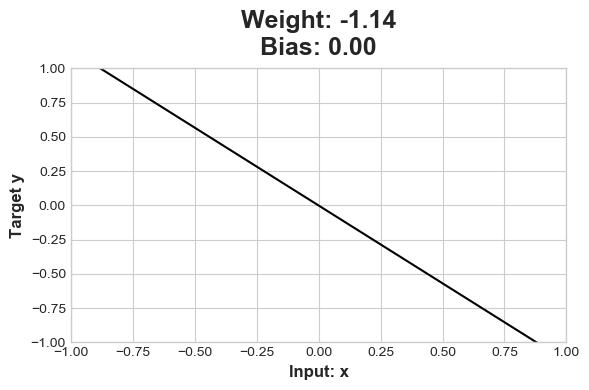

In [10]:
model = keras.Sequential([layers.Dense(1, input_shape=[1]),
                         ])
x = tf.linspace(-1.0, 1.0, 100)
y = model(x)

plt.figure(dpi=100)
plt.plot(x, y, 'k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Input: x")
plt.ylabel("Target y")
w, b = model.weights # you could also use model.get_weights() here
plt.title("Weight: {:0.2f}\nBias: {:0.2f}".format(w[0][0], b[0]))
plt.show()

### Layers

Neural networks typically organize their neurons into layers. When we collect together linear units having a common set of inputs we get a dense layer.

![](./images/2MA4iMV.png)

You could think of each layer in a neural network as performing some kind of relatively simple transformation. Through a deep stack of layers, a neural network can transform its inputs in more and more complex ways. In a well-trained neural network, each layer is a transformation getting us a little bit closer to a solution.

### Many Kinds of Layers
    
A "layer" in Keras is a very general kind of thing. A layer can be, essentially, any kind of data transformation. Many layers, like the convolutional and recurrent layers, transform data through use of neurons and differ primarily in the pattern of connections they form. Others though are used for feature engineering or just simple arithmetic. There's a whole world of layers to discover -- check them out! 

### The Activation Function

It turns out, however, that two dense layers with nothing in between are no better than a single dense layer by itself. Dense layers by themselves can never move us out of the world of lines and planes. What we need is something nonlinear. What we need are activation functions.

![](./images/OLSUEYT.png)

Without activation functions, neural networks can only learn linear relationships. In order to fit curves, we'll need to use activation functions.

An activation function is simply some function we apply to each of a layer's outputs (its activations). The most common is the rectifier function max(0,x).

![](./images/aeIyAlF.png)

The rectifier function has a graph that's a line with the negative part "rectified" to zero. Applying the function to the outputs of a neuron will put a bend in the data, moving us away from simple lines.

When we attach the rectifier to a linear unit, we get a rectified linear unit or ReLU. (For this reason, it's common to call the rectifier function the "ReLU function".) Applying a ReLU activation to a linear unit means the output becomes $max(0, w * x + b)$, which we might draw in a diagram like:

![](./images/eFry7Yu.png)

A rectified linear unit.

### Stacking Dense Layers

Now that we have some nonlinearity, let's see how we can stack layers to get complex data transformations.


![](./images/Y5iwFQZ.png)

A stack of dense layers makes a "fully-connected" network.

The layers before the output layer are sometimes called hidden since we never see their outputs directly. And though we haven't shown them in this diagram each of these neurons would also be receiving a bias (one bias for each neuron).

Now, notice that the final (output) layer is a linear unit (meaning, no activation function). That makes this network appropriate to a regression task, where we are trying to predict some arbitrary numeric value. Other tasks (like classification) might require an activation function on the output.

### Building Sequential Models

The Sequential model we've been using will connect together a list of layers in order from first to last: the first layer gets the input, the last layer produces the output. This creates the model in the figure above:

In [11]:
model = keras.Sequential([layers.Dense(units=4, activation='relu', input_shape=[2]),
                          layers.Dense(units=3, activation='relu'),
                          layers.Dense(units=1),
                         ])

In [12]:
model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[ 0.4406364 ,  0.33187628, -0.90682507,  0.08267188],
        [-0.45887947, -0.8956809 ,  0.01077175, -0.04602957]],
       dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_4/kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.2463662 , -0.12148839, -0.75267005],
        [ 0.3977189 ,  0.63291836, -0.4643435 ],
        [ 0.22742975,  0.13623357, -0.16026407],
        [-0.7438068 , -0.60281   ,  0.8951657 ]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_5/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[ 1.1893412],
        [-1.1465781],
        [-1.0414819]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

we learned how to build fully-connected networks out of stacks of dense layers. When first created, all of the network's weights are set randomly -- the network doesn't "know" anything yet. In this lesson we're going to see how to train a neural network; we're going to see how neural networks learn.

As with all machine learning tasks, we begin with a set of training data. Each example in the training data consists of some features (the inputs) together with an expected target (the output). Training the network means adjusting its weights in such a way that it can transform the features into the target. In the 80 Cereals dataset, for instance, we want a network that can take each cereal's 'sugar', 'fiber', and 'protein' content and produce a prediction for that cereal's 'calories'. If we can successfully train a network to do that, its weights must represent in some way the relationship between those features and that target as expressed in the training data.

In addition to the training data, we need two more things:

    A "loss function" that measures how good the network's predictions are.
    An "optimizer" that can tell the network how to change its weights.

### The Loss Function

We've seen how to design an architecture for a network, but we haven't seen how to tell a network what problem to solve. This is the job of the loss function.

The loss function measures the disparity between the the target's true value and the value the model predicts.

Different problems call for different loss functions. We have been looking at regression problems, where the task is to predict some numerical value -- calories in 80 Cereals, rating in Red Wine Quality. Other regression tasks might be predicting the price of a house or the fuel efficiency of a car.

A common loss function for regression problems is the mean absolute error or MAE. For each prediction y_pred, MAE measures the disparity from the true target y_true by an absolute difference abs(y_true - y_pred).

The total MAE loss on a dataset is the mean of all these absolute differences.

![](./images/VDcvkZN.png)

The mean absolute error is the average length between the fitted curve and the data points.

Besides MAE, other loss functions you might see for regression problems are the mean-squared error (MSE) or the Huber loss (both available in Keras).

During training, the model will use the loss function as a guide for finding the correct values of its weights (lower loss is better). In other words, the loss function tells the network its objective.
The Optimizer - Stochastic Gradient Descent

We've described the problem we want the network to solve, but now we need to say how to solve it. This is the job of the optimizer. The optimizer is an algorithm that adjusts the weights to minimize the loss.

Virtually all of the optimization algorithms used in deep learning belong to a family called stochastic gradient descent. They are iterative algorithms that train a network in steps. One step of training goes like this:

+ Sample some training data and run it through the network to make predictions.
+ Measure the loss between the predictions and the true values.
+ Finally, adjust the weights in a direction that makes the loss smaller.

Then just do this over and over until the loss is as small as you like (or until it won't decrease any further.)

![](./images/rFI1tIk.gif)

### Training a neural network with Stochastic Gradient Descent.

Each iteration's sample of training data is called a minibatch (or often just "batch"), while a complete round of the training data is called an epoch. The number of epochs you train for is how many times the network will see each training example.

The animation shows a linear model being trained with SGD. The pale red dots depict the entire training set, while the solid red dots are the minibatches. Every time SGD sees a new minibatch, it will shift the weights (w the slope and b the y-intercept) toward their correct values on that batch. Batch after batch, the line eventually converges to its best fit. You can see that the loss gets smaller as the weights get closer to their true values.
Learning Rate and Batch Size

Notice that the line only makes a small shift in the direction of each batch (instead of moving all the way). The size of these shifts is determined by the learning rate. A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.

The learning rate and the size of the minibatches are the two parameters that have the largest effect on how the SGD training proceeds. Their interaction is often subtle and the right choice for these parameters isn't always obvious. (We'll explore these effects in the exercise.)

Fortunately, for most work it won't be necessary to do an extensive hyperparameter search to get satisfactory results. Adam is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is "self tuning", in a sense). Adam is a great general-purpose optimizer.

### Adding the Loss and Optimizer

After defining a model, you can add a loss function and optimizer with the model's compile method:

In [13]:
model.compile(optimizer="adam", loss="mae",)

Notice that we are able to specify the loss and optimizer with just a string. You can also access these directly through the Keras API -- if you wanted to tune parameters, for instance -- but for us, the defaults will work fine.

Back to the Red Wine Quality

Now we know everything we need to start training deep learning models. So let's see it in action! We'll use the Red Wine Quality dataset.

This dataset consists of physiochemical measurements from about 1600 Portuguese red wines. Also included is a quality rating for each wine from blind taste-tests. How well can we predict a wine's perceived quality from these measurements?

One thing you might note for now though is that we've rescaled each feature to lie in the interval [0,1]
As we'll discuss more in Lesson 5, neural networks tend to perform best when their inputs are on a common scale.

In [14]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [15]:
# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


How many inputs should this network have? We can discover this by looking at the number of columns in the data matrix. Be sure not to include the target ('quality') here -- only the input features.

In [16]:
len(red_wine.columns) - 1

11



Eleven columns means eleven inputs.

We've chosen a three-layer network with over 1500 neurons. This network should be capable of learning fairly complex relationships in the data.


In [17]:
model = keras.Sequential([layers.Dense(512, activation='relu', input_shape=[11]),
                          layers.Dense(512, activation='relu'),
                          layers.Dense(512, activation='relu'),
                          layers.Dense(1),
                         ])

Deciding the architecture of your model should be part of a process. Start simple and use the validation loss as your guide.

After defining the model, we compile in the optimizer and loss function.

In [18]:
model.compile(optimizer="adam", loss="mae",)

Now we're ready to start the training! We've told Keras to feed the optimizer 256 rows of the training data at a time (the batch_size) and to do that 10 times all the way through the dataset (the epochs).

In [19]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=256,
                    epochs=10,
                   )

Epoch 1/10
5/5 [==============================] - 0s 30ms/step - loss: 0.2875 - val_loss: 0.1365
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - val_loss: 0.1281
Epoch 3/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1336 - val_loss: 0.1194
Epoch 4/10
5/5 [==============================] - 0s 13ms/step - loss: 0.1174 - val_loss: 0.1119
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1106 - val_loss: 0.1096
Epoch 6/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1087 - val_loss: 0.1029
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1050 - val_loss: 0.1039
Epoch 8/10
5/5 [==============================] - 0s 9ms/step - loss: 0.1052 - val_loss: 0.1093
Epoch 9/10
5/5 [==============================] - 0s 8ms/step - loss: 0.1036 - val_loss: 0.1013
Epoch 10/10
5/5 [==============================] - 0s 9ms/step - loss: 0.1031 - val_loss: 0.1003


You can see that Keras will keep you updated on the loss as the model trains.

Often, a better way to view the loss though is to plot it. The fit method in fact keeps a record of the loss produced during training in a History object. We'll convert the data to a Pandas dataframe, which makes the plotting easy.


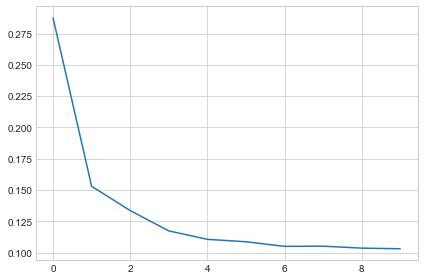

In [20]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

Notice how the loss levels off as the epochs go by. When the loss curve becomes horizontal like that, it means the model has learned all it can and there would be no reason continue for additional epochs.

### Interpreting the Learning Curves

You might think about the information in the training data as being of two kinds: signal and noise. The signal is the part that generalizes, the part that can help our model make predictions from new data. The noise is that part that is only true of the training data; the noise is all of the random fluctuation that comes from data in the real-world or all of the incidental, non-informative patterns that can't actually help the model make predictions. The noise is the part might look useful but really isn't.

We train a model by choosing weights or parameters that minimize the loss on a training set. You might know, however, that to accurately assess a model's performance, we need to evaluate it on a new set of data, the validation data. (You could see our lesson on model validation in Introduction to Machine Learning for a review.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the learning curves. To train deep learning models effectively, we need to be able to interpret them.

![](./images/tHiVFnM.png)

Now, the training loss will go down either when the model learns signal or when it learns noise. But the validation loss will go down only when the model learns signal. (Whatever noise the model learned from the training set won't generalize to new data.) So, when a model learns signal both curves go down, but when it learns noise a gap is created in the curves. The size of the gap tells you how much noise the model has learned.

Ideally, we would create models that learn all of the signal and none of the noise. This will practically never happen. Instead we make a trade. We can get the model to learn more signal at the cost of learning more noise. So long as the trade is in our favor, the validation loss will continue to decrease. After a certain point, however, the trade can turn against us, the cost exceeds the benefit, and the validation loss begins to rise.

![](./images/eUF6mfo.png)

This trade-off indicates that there can be two problems that occur when training a model: not enough signal or too much noise. Underfitting the training set is when the loss is not as low as it could be because the model hasn't learned enough signal. Overfitting the training set is when the loss is not as low as it could be because the model learned too much noise. The trick to training deep learning models is finding the best balance between the two.

We'll look at a couple ways of getting as more signal out of the training data while reducing the amount of noise.

### Capacity

A model's capacity refers to the size and complexity of the patterns it is able to learn. For neural networks, this will largely be determined by how many neurons it has and how they are connected together. If it appears that your network is underfitting the data, you should try increasing its capacity.

You can increase the capacity of a network either by making it wider (more units to existing layers) or by making it deeper (adding more layers). Wider networks have an easier time learning more linear relationships, while deeper networks prefer more nonlinear ones. Which is better just depends on the dataset.

In [21]:
model = keras.Sequential([layers.Dense(16, activation='relu'),
                          layers.Dense(1),
                         ])

wider = keras.Sequential([layers.Dense(32, activation='relu'),
                          layers.Dense(1),
                         ])

deeper = keras.Sequential([layers.Dense(16, activation='relu'),
                           layers.Dense(16, activation='relu'),
                           layers.Dense(1),
                          ])

### Early Stopping

We mentioned that when a model is too eagerly learning noise, the validation loss may start to increase during training. To prevent this, we can simply stop the training whenever it seems the validation loss isn't decreasing anymore. Interrupting the training this way is called early stopping.

![](./images/eP0gppr.png)

We keep the model where the validation loss is at a minimum.

Once we detect that the validation loss is starting to rise again, we can reset the weights back to where the minimum occured. This ensures that the model won't continue to learn noise and overfit the data.

Training with early stopping also means we're in less danger of stopping the training too early, before the network has finished learning signal. So besides preventing overfitting from training too long, early stopping can also prevent underfitting from not training long enough. Just set your training epochs to some large number (more than you'll need), and early stopping will take care of the rest.
Adding Early Stopping

In Keras, we include early stopping in our training through a callback. A callback is just a function you want run every so ofter while the network trains. The early stopping callback will run after every epoch. (Keras has a variety of useful callbacks pre-defined, but you can define your own, too.)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
                               patience=20, # how many epochs to wait before stopping
                               restore_best_weights=True,
                              )

These parameters say: "If there hasn't been at least an improvement of 0.01 in the validation loss over the previous 5 epochs, then stop the training and keep the best model you found." It can sometimes be hard to tell if the validation loss is rising due to overfitting or just due to noise. The parameters allow us to set some allowances around when to stop.

As we'll see in our example, we'll pass this callback to the fit method along with the loss and optimizer.

### Example - Train a Model with Early Stopping

Let's continue developing the model from the example in the last tutorial. We'll increase the capacity of that network but also add an early-stopping callback to prevent overfitting.

Let's increase the capacity of the network. We'll go for a fairly large network, but rely on the callback to halt the training once the validation loss shows signs of increasing

Minimum validation loss: 0.09044142812490463


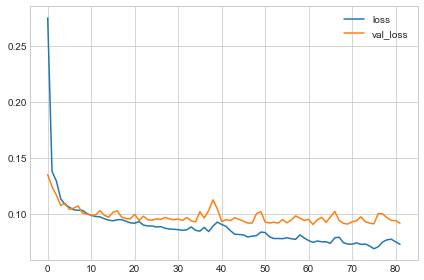

In [23]:
early_stopping = EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
                               patience=20, # how many epochs to wait before stopping
                               restore_best_weights=True,
                              )

model = keras.Sequential([layers.Dense(512, activation='relu', input_shape=[11]),
                          layers.Dense(512, activation='relu'),
                          layers.Dense(512, activation='relu'),
                          layers.Dense(1),
                         ])

model.compile(optimizer='adam',
              loss='mae',
             )

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=256,
                    epochs=500,
                    callbacks=[early_stopping],
                    verbose=0,  # turn off training log
                   )

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

We'll learn about a two kinds of special layers, not containing any neurons themselves, but that add some functionality that can sometimes benefit a model in various ways. Both are commonly used in modern architectures.
Dropout

The first of these is the "dropout layer", which can help correct overfitting.

In the last lesson we talked about how overfitting is caused by the network learning spurious patterns in the training data. To recognize these spurious patterns a network will often rely on very a specific combinations of weight, a kind of "conspiracy" of weights. Being so specific, they tend to be fragile: remove one and the conspiracy falls apart.

This is the idea behind dropout. To break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

![](./images/a86utxY.gif)

Here, 50% dropout has been added between the two hidden layers.

You could also think about dropout as creating a kind of ensemble of networks. The predictions will no longer be made by one big network, but instead by a committee of smaller networks. Individuals in the committee tend to make different kinds of mistakes, but be right at the same time, making the committee as a whole better than any individual. (If you're familiar with random forests as an ensemble of decision trees, it's the same idea.)

### Adding Dropout

In Keras, the dropout rate argument rate defines what percentage of the input units to shut off. Put the Dropout layer just before the layer you want the dropout applied to:

### Batch Normalization

The next special layer we'll look at performs "batch normalization" (or "batchnorm"), which can help correct training that is slow or unstable.

With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler. The reason is that SGD will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.

Now, if it's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! In fact, we have a special kind of layer that can do this, the batch normalization layer. A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batchnorm, in effect, performs a kind of coordinated rescaling of its inputs.

Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training.

### Adding Batch Normalization

It seems that batch normalization can be used at almost any point in a network. You can put it after a layer...

In [24]:
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),

(<tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x1bda883b208>,)

... or between a layer and its activation function:

In [25]:
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),

(<tensorflow.python.keras.layers.core.Activation at 0x1bda8824b48>,)

And if you add it as the first layer of your network it can act as a kind of adaptive preprocessor, standing in for something like Sci-Kit Learn's StandardScaler.

### Example - Using Dropout and Batch Normalization

Let's continue developing the Red Wine model. Now we'll increase the capacity even more, but add dropout to control overfitting and batch normalization to speed up optimization. This time, we'll also leave off standardizing the data, to demonstrate how batch normalization can stabilize the training.

In [26]:
model = keras.Sequential([layers.Dense(1024, activation='relu', input_shape=[11]),
                          layers.Dropout(0.3),
                          layers.BatchNormalization(),
                          layers.Dense(1024, activation='relu'),
                          layers.Dropout(0.3),
                          layers.BatchNormalization(),
                          layers.Dense(1024, activation='relu'),
                          layers.Dropout(0.3),
                          layers.BatchNormalization(),
                          layers.Dense(1),
                         ])

model.compile(optimizer='adam', loss='mae',)

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=256,
                    epochs=100,
                    verbose=0,
                   )

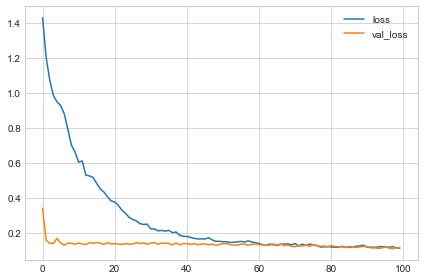

In [27]:
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

You'll typically get better performance if you standardize your data before using it for training. That we were able to use the raw data at all, however, shows how effective batch normalization can be on more difficult datasets.

So far, we've learned about how neural networks can solve regression problems. Now we're going to apply neural networks to another common machine learning problem: classification. Most everything we've learned up until now still applies. The main difference is in the loss function we use and in what kind of outputs we want the final layer to produce.

### Binary Classification

Classification into one of two classes is a common machine learning problem. You might want to predict whether or not a customer is likely to make a purchase, whether or not a credit card transaction was fraudulent, whether deep space signals show evidence of a new planet, or a medical test evidence of a disease. These are all binary classification problems.

In your raw data, the classes might be represented by strings like "Yes" and "No", or "Dog" and "Cat". Before using this data we'll assign a class label: one class will be 0 and the other will be 1. Assigning numeric labels puts the data in a form a neural network can use.

### Accuracy and Cross-Entropy

Accuracy is one of the many metrics in use for measuring success on a classification problem. Accuracy is the ratio of correct predictions to total predictions: accuracy = number_correct / total. A model that always predicted correctly would have an accuracy score of 1.0. All else being equal, accuracy is a reasonable metric to use whenever the classes in the dataset occur with about the same frequency.

The problem with accuracy (and most other classification metrics) is that it can't be used as a loss function. SGD needs a loss function that changes smoothly, but accuracy, being a ratio of counts, changes in "jumps". So, we have to choose a substitute to act as the loss function. This substitute is the *cross-entropy function*.

Now, recall that the loss function defines the objective of the network during training. With regression, our goal was to minimize the distance between the expected outcome and the predicted outcome. We chose MAE to measure this distance.

For classification, what we want instead is a distance between probabilities, and this is what cross-entropy provides. Cross-entropy is a sort of measure for the distance from one probability distribution to another.

![](./images/DwVV9bR.png)

The idea is that we want our network to predict the correct class with probability 1.0. The further away the predicted probability is from 1.0, the greater will be the cross-entropy loss.

The technical reasons we use cross-entropy are a bit subtle, but the main thing to take away from this section is just this: use cross-entropy for a classification loss; other metrics you might care about (like accuracy) will tend to improve along with it.

### Making Probabilities with the Sigmoid Function

The cross-entropy and accuracy functions both require probabilities as inputs, meaning, numbers from 0 to 1. To covert the real-valued outputs produced by a dense layer into probabilities, we attach a new kind of activation function, the sigmoid activation.

![](./images/FYbRvJo.png)

To get the final class prediction, we define a threshold probability. Typically this will be 0.5, so that rounding will give us the correct class: below 0.5 means the class with label 0 and 0.5 or above means the class with label 1. A 0.5 threshold is what Keras uses by default with its accuracy metric.
Example - Binary Classification

Now let's try it out!

The Ionosphere dataset contains features obtained from radar signals focused on the ionosphere layer of the Earth's atmosphere. The task is to determine whether the signal shows the presence of some object, or just empty air.

In [28]:
ion = pd.read_csv('../../data/ion.csv', index_col=0)
display(ion.head())

df = ion.copy()
df['Class'] = df['Class'].map({'good': 0, 'bad': 1})

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True) # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

X_train = df_train.drop('Class', axis=1)
X_valid = df_valid.drop('Class', axis=1)
y_train = df_train['Class']
y_valid = df_valid['Class']

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,good
2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,bad
3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,good
4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,bad
5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,good


We'll define our model just like we did for the regression tasks, with one exception. In the final layer include a 'sigmoid' activation so that the model will produce class probabilities.

In [29]:
model = keras.Sequential([layers.Dense(4, activation='relu', input_shape=[33]),
                          layers.Dense(4, activation='relu'),
                          layers.Dense(1, activation='sigmoid'),
                         ])

Add the cross-entropy loss and accuracy metric to the model with its compile method. For two-class problems, be sure to use 'binary' versions. (Problems with more classes will be slightly different.) The Adam optimizer works great for classification too, so we'll stick with it.

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy',],
             )

The model in this particular problem can take quite a few epochs to complete training, so we'll include an early stopping callback for convenience.

In [31]:
early_stopping = keras.callbacks.EarlyStopping(patience=30,
                                               min_delta=0.001,
                                               restore_best_weights=True,
                                              )

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=512,
                    epochs=1000,
                    callbacks=[early_stopping],
                    verbose=0, # hide the output because we have so many epochs
                   )

We'll take a look at the learning curves as always, and also inspect the best values for the loss and accuracy we got on the validation set. (Remember that early stopping will restore the weights to those that got these values.)

Best Validation Loss: 0.2928
Best Validation Accuracy: 0.9048


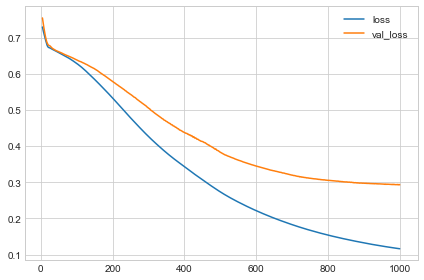

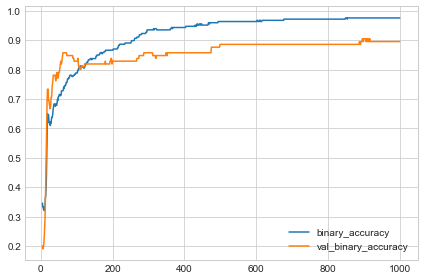

In [32]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))